# MultiCat Image Classification
> Creating a multi category image classifier!

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

In this post we will be creating a multi-category classifier.  This means one image may have 1, 2, or more labels and we want to identify and label them all correctly.  Let's get started!

# Get Data

In [63]:
from fastai2.vision.all import *
import pandas as pd
from functools import partial
warnings.filterwarnings("ignore")

path = untar_data(URLs.PASCAL_2007)

In [64]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [65]:
dls = ImageDataLoaders.from_df(train, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

As you can see from the batch below, images have different number of labels depending on what is in the picture.

In [66]:
dls.show_batch()

# Modeling

### Loss Function

With this multi-category, we use binary cross-entropy instead of normal cross-entropy.  This is because normal cross entropy uses a softmax, which makes all probabilities add to 1.  That makes a ton of sense when we only have 1 class, but with multiple it doesn't.  Softmax in the loss function makes it much harder to train as it forces class probabilities to sum to 1, when there may in fact have multiple classes (or no classes).

In [67]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

### Training

We will use a resnet34 architecture, using a pretrained model.  The first thing we will want to do is freeze the model and train the last layer, as that is not transferrable from the pretrained model.

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.033113110810518265)

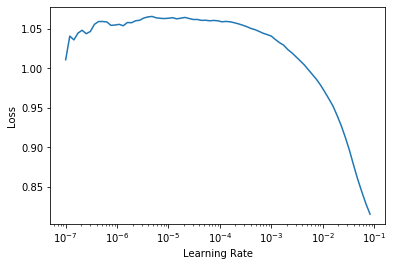

In [68]:
learn = cnn_learner(dls,arch = resnet34,metrics = accuracy_multi,loss_func=binary_cross_entropy)

learn.freeze()
learn.lr_find()

In [69]:
# Training last layer for 4 epochs
learn.fit_one_cycle(4,5e-2)

Next we will unfreeze our model, meaning we will train all layers in our model.  You will notice I am using discriminative learning rates, which is key.  Early layers should not have weights adjusted as fast as later laters.

>Note: Discriminative learning rates means we use a smaller learning rate for earlier layers in the model.  This is what ```slice(1e-4/100,1e-4)``` is doing. 

In [70]:
learn.unfreeze()
learn.lr_find()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=9.999999747378752e-06)

In [71]:
learn.fit_one_cycle(4,slice(1e-4/100,1e-4))

For our final steps, I will train the last couple of layers with the earlier layers frozen

In [72]:
learn.freeze_to(-2)
learn.lr_find()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

In [73]:
learn.fit_one_cycle(2, 1e-5)

In [74]:
learn.freeze_to(-1)
learn.lr_find()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.918309736647643e-06)

In [75]:
learn.fit_one_cycle(3,5e-3)

Just over 96% accuracy - Not bad!  When we look at the labels over the images, we can see it actually did a pretty good job identiffying what is in the images/

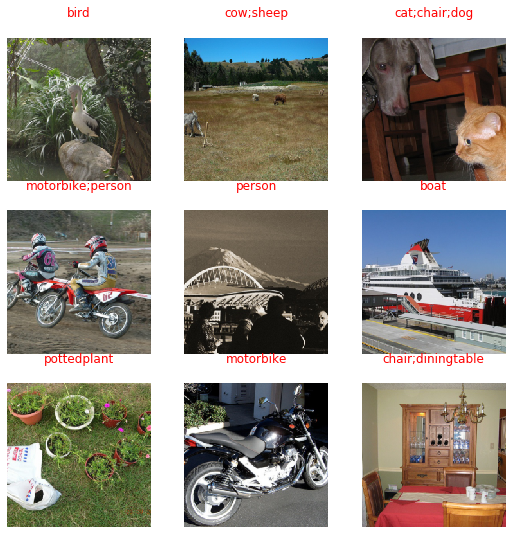

In [79]:
learn.show_results()

### Accuracy Threshhold

One last thing to consider with multi-category is the accuracy threshhold.  If a class score is > 0.5, should we consider that class a match?  Or should it require a score of > 0.6?  I reccomend playing with the threshold to see what works for your application.  You can print many metrics during training by passing a list of metrics to the metrics argument.

In [62]:
learn = cnn_learner(dls,arch = resnet34,metrics = [partial(accuracy_multi,thresh=x) for x in np.array(range(1,10))/10])
learn.fine_tune(1)